In [1]:
from tensorflow.config import list_physical_devices
from tensorflow.keras import mixed_precision
from tensorflow.config.experimental import set_memory_growth
from tensorflow.keras import callbacks

2022-10-18 18:14:26.012895: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Variables set up

In [2]:
MAX_LEN = 512
NUM_HEAD = 8
FF_DIM = 1024
NUM_LAYERS = 8
EMBED_DIM = 256

BATCH_SIZE = 256
LR = 0.0004

### GPU set up

In [3]:
gpus = list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        set_memory_growth(gpu, True)
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


2022-10-18 18:14:27.331918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 18:14:27.349077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 18:14:27.349777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 18:14:27.350896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Pre-processing

In [4]:
from os import listdir
import gdown
from processing import load_dicts, count_samples, data_generator

### Download the data

In [5]:
folder_url = 'https://drive.google.com/drive/folders/1rk9HhT6OtrGlqC2ZGT0eREFc8FH2F8QJ?usp=sharing'
if 'data' not in listdir():
    gdown.download_folder(folder_url)
    ! mv char_paragraphs data

Retrieving folder list


Processing file 1iXflqpzg-9dIBTs4ZejCTfusgu-dUHpN test_paragraphs.txt
Processing file 14s-iXY0PKEOIGtZnX-yweFtgz31owdFG train_paragraphs.txt
Processing file 1xASDq01S0Zis8PBNN8ZAUtTD6ZEhso4V val_paragraphs.txt
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1iXflqpzg-9dIBTs4ZejCTfusgu-dUHpN
To: /home/mkrtich/arm_mlm/char_paragraphs/test_paragraphs.txt
100%|██████████| 99.5M/99.5M [00:02<00:00, 33.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=14s-iXY0PKEOIGtZnX-yweFtgz31owdFG
To: /home/mkrtich/arm_mlm/char_paragraphs/train_paragraphs.txt
100%|██████████| 799M/799M [00:26<00:00, 30.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1xASDq01S0Zis8PBNN8ZAUtTD6ZEhso4V
To: /home/mkrtich/arm_mlm/char_paragraphs/val_paragraphs.txt
100%|██████████| 99.5M/99.5M [00:02<00:00, 33.3MB/s]

/bin/bash: /home/mkrtich/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)



Download completed


### Load the dictionaries

In [6]:
char2idx, idx2char = load_dicts()
MASK_ID = len(char2idx)
VOCAB_SIZE = MASK_ID


files not existing. created new files.


### Make data generators

In [7]:
N_TRAIN = count_samples('data/train_paragraphs.txt')
N_STEPS = int(N_TRAIN/BATCH_SIZE)+1
N_VAL = count_samples('data/val_paragraphs.txt')
N_STEPS_VAL= int(N_VAL/BATCH_SIZE)+1
N_TEST = count_samples('data/test_paragraphs.txt')
N_STEPS_TEST= int(N_TEST/BATCH_SIZE)+1
print(' Train, Val, Test\n', N_TRAIN, N_VAL, N_TEST)

 Train, Val, Test
 1159732 144965 144969


In [8]:
train_gen = data_generator('data/train_paragraphs.txt', max_len=512, masking=True, batch_size=256, vocab=char2idx, mask_id=None)
val_gen = data_generator('data/val_paragraphs.txt', max_len=512, masking=True, batch_size=256, vocab=char2idx, mask_id=None)
test_gen = data_generator('data/test_paragraphs.txt', max_len=512, masking=True, batch_size=256, vocab=char2idx, mask_id=None)

# Modeling

In [9]:
from modeling import ModelConfigurator, MaskedLanguageModel, create_mlm, plot_history

2022-10-18 18:15:15.236781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 18:15:15.238357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 18:15:15.239119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 18:15:15.239826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

### Set up model variables

In [10]:
mc = ModelConfigurator(
    MAX_LEN,NUM_HEAD,
    FF_DIM,
    NUM_LAYERS,
    EMBED_DIM,
    LR)

### Create the model

In [11]:
masked_model = create_mlm(mc, VOCAB_SIZE)
masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 512, 256)     47360       ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 512, 256)    0           ['word_embedding[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder_0/multiheadattention (  (None, 512, 256)    263168      ['tf.__operators_

### Train the model

In [12]:
def scheduler(epoch, lr):
    if epoch < 22:
        lr = LR
    elif epoch < 52:
        lr = LR/6
    else:
        lr = LR/36
    return lr
lr_callback = callbacks.LearningRateScheduler(scheduler)


checkpoint = callbacks.ModelCheckpoint(
    filepath='models/TF_char_6412k',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
    )

hist = masked_model.fit(
    train_gen, epochs=65,
    steps_per_epoch=N_STEPS,
    validation_steps=N_STEPS_VAL,
    validation_data=val_gen,
    callbacks=[lr_callback, checkpoint]
    )

Epoch 1/65
4531/4531 [==============================] - ETA: 0s - loss: 2.0213 - accuracy: 0.2678
Epoch 1: val_loss improved from inf to 0.90695, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3303s 728ms/step - loss: 2.0213 - accuracy: 0.2679 - val_loss: 0.9069 - val_accuracy: 0.7399 - lr: 4.0000e-04
Epoch 2/65
4531/4531 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.7491
Epoch 2: val_loss improved from 0.90695 to 0.56812, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3305s 729ms/step - loss: 0.7824 - accuracy: 0.7491 - val_loss: 0.5681 - val_accuracy: 0.8363 - lr: 4.0000e-04
Epoch 3/65
4531/4531 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.8264
Epoch 3: val_loss improved from 0.56812 to 0.45074, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3296s 727ms/step - loss: 0.5684 - accuracy: 0.8264 - val_loss: 0.4507 - val_accuracy: 0.8703 - lr: 4.0000e-04
Epoch 4/65
4531/4531 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8562
Epoch 4: val_loss improved from 0.45074 to 0.39126, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3299s 728ms/step - loss: 0.4799 - accuracy: 0.8562 - val_loss: 0.3913 - val_accuracy: 0.8861 - lr: 4.0000e-04
Epoch 5/65
4531/4531 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8717
Epoch 5: val_loss improved from 0.39126 to 0.35758, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3285s 725ms/step - loss: 0.4318 - accuracy: 0.8717 - val_loss: 0.3576 - val_accuracy: 0.8956 - lr: 4.0000e-04
Epoch 6/65
4531/4531 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8814
Epoch 6: val_loss improved from 0.35758 to 0.33567, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3285s 725ms/step - loss: 0.4003 - accuracy: 0.8814 - val_loss: 0.3357 - val_accuracy: 0.9024 - lr: 4.0000e-04
Epoch 7/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8882
Epoch 7: val_loss improved from 0.33567 to 0.31618, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3285s 725ms/step - loss: 0.3779 - accuracy: 0.8882 - val_loss: 0.3162 - val_accuracy: 0.9074 - lr: 4.0000e-04
Epoch 8/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8935
Epoch 8: val_loss improved from 0.31618 to 0.30695, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3285s 725ms/step - loss: 0.3604 - accuracy: 0.8935 - val_loss: 0.3069 - val_accuracy: 0.9110 - lr: 4.0000e-04
Epoch 9/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8977
Epoch 9: val_loss improved from 0.30695 to 0.29306, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3284s 725ms/step - loss: 0.3467 - accuracy: 0.8977 - val_loss: 0.2931 - val_accuracy: 0.9148 - lr: 4.0000e-04
Epoch 10/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.9009
Epoch 10: val_loss improved from 0.29306 to 0.28395, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3283s 725ms/step - loss: 0.3357 - accuracy: 0.9009 - val_loss: 0.2839 - val_accuracy: 0.9169 - lr: 4.0000e-04
Epoch 11/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.9037
Epoch 11: val_loss improved from 0.28395 to 0.27746, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3239s 715ms/step - loss: 0.3266 - accuracy: 0.9037 - val_loss: 0.2775 - val_accuracy: 0.9192 - lr: 4.0000e-04
Epoch 12/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9060
Epoch 12: val_loss improved from 0.27746 to 0.27082, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3244s 716ms/step - loss: 0.3187 - accuracy: 0.9060 - val_loss: 0.2708 - val_accuracy: 0.9208 - lr: 4.0000e-04
Epoch 13/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9083
Epoch 13: val_loss improved from 0.27082 to 0.26237, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3236s 714ms/step - loss: 0.3113 - accuracy: 0.9083 - val_loss: 0.2624 - val_accuracy: 0.9232 - lr: 4.0000e-04
Epoch 14/65
4531/4531 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9100
Epoch 14: val_loss improved from 0.26237 to 0.25931, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3238s 715ms/step - loss: 0.3054 - accuracy: 0.9100 - val_loss: 0.2593 - val_accuracy: 0.9245 - lr: 4.0000e-04
Epoch 15/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.9118
Epoch 15: val_loss improved from 0.25931 to 0.25697, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3244s 716ms/step - loss: 0.2997 - accuracy: 0.9118 - val_loss: 0.2570 - val_accuracy: 0.9253 - lr: 4.0000e-04
Epoch 16/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.9130
Epoch 16: val_loss improved from 0.25697 to 0.24945, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3217s 710ms/step - loss: 0.2953 - accuracy: 0.9130 - val_loss: 0.2494 - val_accuracy: 0.9271 - lr: 4.0000e-04
Epoch 17/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9145
Epoch 17: val_loss improved from 0.24945 to 0.24684, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3217s 710ms/step - loss: 0.2906 - accuracy: 0.9145 - val_loss: 0.2468 - val_accuracy: 0.9280 - lr: 4.0000e-04
Epoch 18/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9158
Epoch 18: val_loss improved from 0.24684 to 0.24452, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3216s 710ms/step - loss: 0.2861 - accuracy: 0.9158 - val_loss: 0.2445 - val_accuracy: 0.9290 - lr: 4.0000e-04
Epoch 19/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9169
Epoch 19: val_loss improved from 0.24452 to 0.24235, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2822 - accuracy: 0.9169 - val_loss: 0.2423 - val_accuracy: 0.9298 - lr: 4.0000e-04
Epoch 20/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9178
Epoch 20: val_loss improved from 0.24235 to 0.23829, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3217s 710ms/step - loss: 0.2792 - accuracy: 0.9178 - val_loss: 0.2383 - val_accuracy: 0.9308 - lr: 4.0000e-04
Epoch 21/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9188
Epoch 21: val_loss improved from 0.23829 to 0.23516, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3216s 710ms/step - loss: 0.2759 - accuracy: 0.9188 - val_loss: 0.2352 - val_accuracy: 0.9316 - lr: 4.0000e-04
Epoch 22/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9197
Epoch 22: val_loss improved from 0.23516 to 0.23356, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3217s 710ms/step - loss: 0.2731 - accuracy: 0.9197 - val_loss: 0.2336 - val_accuracy: 0.9320 - lr: 4.0000e-04
Epoch 23/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.9251
Epoch 23: val_loss improved from 0.23356 to 0.21267, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2498 - accuracy: 0.9251 - val_loss: 0.2127 - val_accuracy: 0.9378 - lr: 6.6667e-05
Epoch 24/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9281
Epoch 24: val_loss improved from 0.21267 to 0.20939, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3216s 710ms/step - loss: 0.2419 - accuracy: 0.9281 - val_loss: 0.2094 - val_accuracy: 0.9387 - lr: 6.6667e-05
Epoch 25/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9292
Epoch 25: val_loss improved from 0.20939 to 0.20793, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3233s 714ms/step - loss: 0.2389 - accuracy: 0.9292 - val_loss: 0.2079 - val_accuracy: 0.9391 - lr: 6.6667e-05
Epoch 26/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9299
Epoch 26: val_loss improved from 0.20793 to 0.20536, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3242s 716ms/step - loss: 0.2366 - accuracy: 0.9299 - val_loss: 0.2054 - val_accuracy: 0.9398 - lr: 6.6667e-05
Epoch 27/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9303
Epoch 27: val_loss improved from 0.20536 to 0.20348, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3240s 715ms/step - loss: 0.2351 - accuracy: 0.9303 - val_loss: 0.2035 - val_accuracy: 0.9403 - lr: 6.6667e-05
Epoch 28/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9307
Epoch 28: val_loss did not improve from 0.20348
4531/4531 [==============================] - 3212s 709ms/step - loss: 0.2337 - accuracy: 0.9307 - val_loss: 0.2037 - val_accuracy: 0.9404 - lr: 6.6667e-05
Epoch 29/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9312
Epoch 29: val_loss improved from 0.20348 to 0.20061, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3217s 710ms/step - loss: 0.2322 - accuracy: 0.9312 - val_loss: 0.2006 - val_accuracy: 0.9410 - lr: 6.6667e-05
Epoch 30/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9315
Epoch 30: val_loss improved from 0.20061 to 0.20017, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2312 - accuracy: 0.9315 - val_loss: 0.2002 - val_accuracy: 0.9414 - lr: 6.6667e-05
Epoch 31/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9318
Epoch 31: val_loss improved from 0.20017 to 0.19923, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3242s 716ms/step - loss: 0.2303 - accuracy: 0.9318 - val_loss: 0.1992 - val_accuracy: 0.9415 - lr: 6.6667e-05
Epoch 32/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9320
Epoch 32: val_loss improved from 0.19923 to 0.19911, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3237s 714ms/step - loss: 0.2294 - accuracy: 0.9320 - val_loss: 0.1991 - val_accuracy: 0.9416 - lr: 6.6667e-05
Epoch 33/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9322
Epoch 33: val_loss improved from 0.19911 to 0.19722, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3228s 712ms/step - loss: 0.2284 - accuracy: 0.9322 - val_loss: 0.1972 - val_accuracy: 0.9421 - lr: 6.6667e-05
Epoch 34/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9326
Epoch 34: val_loss improved from 0.19722 to 0.19688, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3223s 711ms/step - loss: 0.2273 - accuracy: 0.9326 - val_loss: 0.1969 - val_accuracy: 0.9422 - lr: 6.6667e-05
Epoch 35/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9327
Epoch 35: val_loss improved from 0.19688 to 0.19672, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3198s 706ms/step - loss: 0.2269 - accuracy: 0.9327 - val_loss: 0.1967 - val_accuracy: 0.9423 - lr: 6.6667e-05
Epoch 36/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9328
Epoch 36: val_loss improved from 0.19672 to 0.19489, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3199s 706ms/step - loss: 0.2263 - accuracy: 0.9328 - val_loss: 0.1949 - val_accuracy: 0.9426 - lr: 6.6667e-05
Epoch 37/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9331
Epoch 37: val_loss did not improve from 0.19489
4531/4531 [==============================] - 3209s 708ms/step - loss: 0.2254 - accuracy: 0.9331 - val_loss: 0.1964 - val_accuracy: 0.9425 - lr: 6.6667e-05
Epoch 38/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9331
Epoch 38: val_loss improved from 0.19489 to 0.19395, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2250 - accuracy: 0.9331 - val_loss: 0.1940 - val_accuracy: 0.9430 - lr: 6.6667e-05
Epoch 39/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9334
Epoch 39: val_loss did not improve from 0.19395
4531/4531 [==============================] - 3214s 709ms/step - loss: 0.2244 - accuracy: 0.9334 - val_loss: 0.1945 - val_accuracy: 0.9430 - lr: 6.6667e-05
Epoch 40/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9336
Epoch 40: val_loss improved from 0.19395 to 0.19181, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3220s 711ms/step - loss: 0.2239 - accuracy: 0.9336 - val_loss: 0.1918 - val_accuracy: 0.9435 - lr: 6.6667e-05
Epoch 41/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9338
Epoch 41: val_loss did not improve from 0.19181
4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2232 - accuracy: 0.9338 - val_loss: 0.1934 - val_accuracy: 0.9432 - lr: 6.6667e-05
Epoch 42/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9339
Epoch 42: val_loss did not improve from 0.19181
4531/4531 [==============================] - 3224s 712ms/step - loss: 0.2226 - accuracy: 0.9339 - val_loss: 0.1928 - val_accuracy: 0.9433 - lr: 6.6667e-05
Epoch 43/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9341
Epoch 43: val_loss did not improve from 0.19181
4531/4531 [==============================] - 3226s 712ms/step - loss: 0.2219 - accuracy: 0.934

INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3234s 714ms/step - loss: 0.2211 - accuracy: 0.9344 - val_loss: 0.1913 - val_accuracy: 0.9438 - lr: 6.6667e-05
Epoch 46/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9345
Epoch 46: val_loss improved from 0.19129 to 0.18994, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3196s 705ms/step - loss: 0.2206 - accuracy: 0.9345 - val_loss: 0.1899 - val_accuracy: 0.9441 - lr: 6.6667e-05
Epoch 47/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9347
Epoch 47: val_loss did not improve from 0.18994
4531/4531 [==============================] - 3191s 704ms/step - loss: 0.2202 - accuracy: 0.9347 - val_loss: 0.1900 - val_accuracy: 0.9442 - lr: 6.6667e-05
Epoch 48/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9348
Epoch 48: val_loss did not improve from 0.18994
4531/4531 [==============================] - 3199s 706ms/step - loss: 0.2197 - accuracy: 0.9348 - val_loss: 0.1902 - val_accuracy: 0.9442 - lr: 6.6667e-05
Epoch 49/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9349
Epoch 49: val_loss improved from 0.18994 to 0.18903, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3220s 711ms/step - loss: 0.2193 - accuracy: 0.9349 - val_loss: 0.1890 - val_accuracy: 0.9445 - lr: 6.6667e-05
Epoch 50/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9350
Epoch 50: val_loss did not improve from 0.18903
4531/4531 [==============================] - 3218s 710ms/step - loss: 0.2189 - accuracy: 0.9350 - val_loss: 0.1892 - val_accuracy: 0.9444 - lr: 6.6667e-05
Epoch 51/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9351
Epoch 51: val_loss improved from 0.18903 to 0.18836, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3233s 713ms/step - loss: 0.2184 - accuracy: 0.9351 - val_loss: 0.1884 - val_accuracy: 0.9446 - lr: 6.6667e-05
Epoch 52/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9352
Epoch 52: val_loss improved from 0.18836 to 0.18675, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3200s 706ms/step - loss: 0.2182 - accuracy: 0.9352 - val_loss: 0.1868 - val_accuracy: 0.9450 - lr: 6.6667e-05
Epoch 53/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9359
Epoch 53: val_loss improved from 0.18675 to 0.18536, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3196s 705ms/step - loss: 0.2152 - accuracy: 0.9359 - val_loss: 0.1854 - val_accuracy: 0.9454 - lr: 1.1111e-05
Epoch 54/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9363
Epoch 54: val_loss improved from 0.18536 to 0.18480, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3222s 711ms/step - loss: 0.2141 - accuracy: 0.9363 - val_loss: 0.1848 - val_accuracy: 0.9457 - lr: 1.1111e-05
Epoch 55/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9367
Epoch 55: val_loss did not improve from 0.18480
4531/4531 [==============================] - 3223s 711ms/step - loss: 0.2132 - accuracy: 0.9367 - val_loss: 0.1852 - val_accuracy: 0.9455 - lr: 1.1111e-05
Epoch 56/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9368
Epoch 56: val_loss improved from 0.18480 to 0.18471, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3246s 716ms/step - loss: 0.2128 - accuracy: 0.9368 - val_loss: 0.1847 - val_accuracy: 0.9455 - lr: 1.1111e-05
Epoch 57/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9369
Epoch 57: val_loss improved from 0.18471 to 0.18342, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3237s 714ms/step - loss: 0.2125 - accuracy: 0.9369 - val_loss: 0.1834 - val_accuracy: 0.9460 - lr: 1.1111e-05
Epoch 58/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9368
Epoch 58: val_loss did not improve from 0.18342
4531/4531 [==============================] - 3220s 711ms/step - loss: 0.2125 - accuracy: 0.9368 - val_loss: 0.1846 - val_accuracy: 0.9457 - lr: 1.1111e-05
Epoch 59/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9369
Epoch 59: val_loss did not improve from 0.18342
4531/4531 [==============================] - 3229s 713ms/step - loss: 0.2123 - accuracy: 0.9369 - val_loss: 0.1840 - val_accuracy: 0.9458 - lr: 1.1111e-05
Epoch 60/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9369
Epoch 60: val_loss did not improve from 0.18342
4531/4531 [==============================] - 3233s 713ms/step - loss: 0.2123 - accuracy: 0.936

INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3243s 716ms/step - loss: 0.2118 - accuracy: 0.9370 - val_loss: 0.1831 - val_accuracy: 0.9461 - lr: 1.1111e-05
Epoch 63/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9371
Epoch 63: val_loss did not improve from 0.18310
4531/4531 [==============================] - 3234s 714ms/step - loss: 0.2114 - accuracy: 0.9371 - val_loss: 0.1832 - val_accuracy: 0.9461 - lr: 1.1111e-05
Epoch 64/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9371
Epoch 64: val_loss did not improve from 0.18310
4531/4531 [==============================] - 3242s 716ms/step - loss: 0.2114 - accuracy: 0.9371 - val_loss: 0.1832 - val_accuracy: 0.9460 - lr: 1.1111e-05
Epoch 65/65
4531/4531 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9372
Epoch 65: val_loss improved from 0.18310 to 0.18299, saving model to models/TF_char_6412k


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


INFO:tensorflow:Assets written to: models/TF_char_6412k/assets


4531/4531 [==============================] - 3249s 717ms/step - loss: 0.2114 - accuracy: 0.9372 - val_loss: 0.1830 - val_accuracy: 0.9462 - lr: 1.1111e-05


# Evaluation

### Plot training metrics

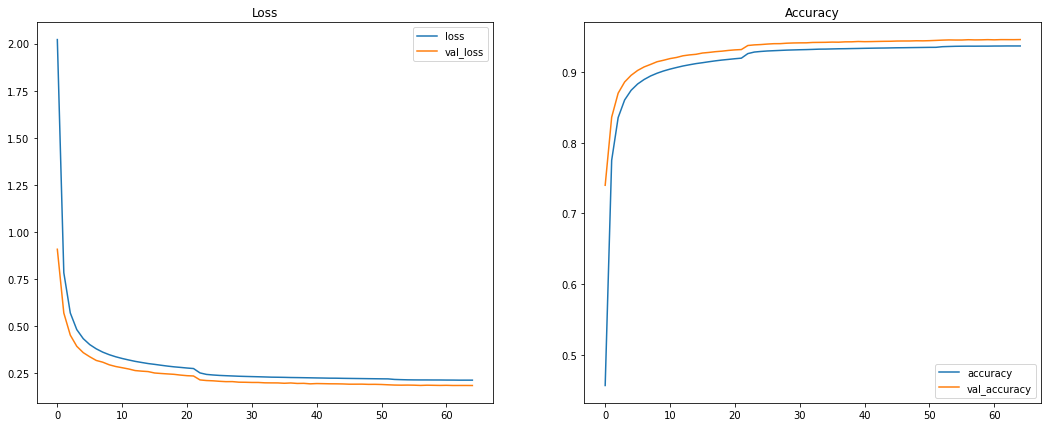

In [13]:
plot_history(hist)

### Evaluate on test set

In [16]:
masked_model.evaluate(test_gen, steps=N_STEPS_TEST, batch_size=BATCH_SIZE)

567/567 [==============================] - 139s 246ms/step - loss: 0.1835 - accuracy: 0.9460


[0.1835266500711441, 0.9459105730056763]